In [1]:
import os
import csv
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim 
from torchvision import transforms, datasets
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
from datetime import datetime
import torchvision.models as models
import random
import numpy as np


In [2]:
# 画像のサイズ
IMG_SIZE = 224

# データのディレクトリのパス
FLOWER_DIR = '../input/flowers'

batch_size = 128


In [3]:
# GPUが利用可能かどうかを確認し、利用可能ならGPUを使用
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')


Using device: cuda


# データセットの作成

In [4]:
transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)), # 画像サイズをリサイズ,
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# データセットを作成
dataset = datasets.ImageFolder(FLOWER_DIR, transform=transforms)


In [5]:
# 学習データに使用する割合
n_train_ratio = 0.8

# 割合から個数を出す
n_train = int(len(dataset) * n_train_ratio)
n_val   = int(len(dataset) - n_train)


In [6]:
# 学習データと検証データに分割
train, val = random_split(dataset, [n_train, n_val])


In [7]:
# Data Loader
train_loader = DataLoader(train, batch_size, shuffle=True, drop_last=True, num_workers=2)
val_loader = DataLoader(val, batch_size, num_workers=2)


In [8]:
# ResNet-34モデルの定義
class CustomResNet34(nn.Module):
    def __init__(self, num_classes):
        super(CustomResNet34, self).__init__()
        self.resnet = models.resnet34(weights="IMAGENET1K_V1")  # 事前学習済みのResNet-34モデルをロード
        # 最終の全結合層を入れ替えて、出力クラスの数に合わせる
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_features, num_classes)

    def forward(self, x):
        return self.resnet(x)


In [9]:
# 2. モデルの構築
model = CustomResNet34(num_classes=5).to(device)


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /home/taisei/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 45.1MB/s]


In [10]:
# 3. 訓練と検証
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5)



In [11]:
def train_and_evaluate_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        # 訓練フェーズ
        model.train()
        train_loss, train_correct = 0, 0
        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}, Training...'):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad(set_to_none=True)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            train_correct += (predicted == labels).sum().item()

        # 検証フェーズ
        model.eval()
        val_loss, val_correct = 0, 0
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs}, Validation...'):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()

        # 損失と精度の計算
        train_losses.append(train_loss / len(train_loader))
        val_losses.append(val_loss / len(val_loader))
        train_accuracies.append(train_correct / len(train_loader.dataset))
        val_accuracies.append(val_correct / len(val_loader.dataset))

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}, Train Acc: {train_accuracies[-1]}, Val Acc: {val_accuracies[-1]}')

    return train_losses, val_losses, train_accuracies, val_accuracies


In [12]:
train_losses, val_losses, train_accuracies, val_accuracies = train_and_evaluate_model(model, train_loader, val_loader, criterion, optimizer)


Epoch 1/50, Validation...: 100%|██████████| 7/7 [00:01<00:00,  4.17it/s]


Epoch 1/50, Train Loss: 0.6521964554603283, Val Loss: 1.8885375431605749, Train Acc: 0.7318273964668405, Val Acc: 0.6643518518518519


Epoch 2/50, Validation...: 100%|██████████| 7/7 [00:01<00:00,  3.66it/s]


Epoch 2/50, Train Loss: 0.3663259589901337, Val Loss: 0.7759735413960048, Train Acc: 0.8467998841587026, Val Acc: 0.8391203703703703


Epoch 3/50, Validation...: 100%|██████████| 7/7 [00:01<00:00,  3.59it/s]


Epoch 3/50, Train Loss: 0.2814439202730472, Val Loss: 0.6764177850314549, Train Acc: 0.8690993339125398, Val Acc: 0.7939814814814815


Epoch 4/50, Validation...: 100%|██████████| 7/7 [00:01<00:00,  3.58it/s]


Epoch 4/50, Train Loss: 0.23942365783911485, Val Loss: 0.5127905011177063, Train Acc: 0.8838690993339126, Val Acc: 0.8055555555555556


Epoch 5/50, Validation...: 100%|██████████| 7/7 [00:02<00:00,  3.36it/s]


Epoch 5/50, Train Loss: 0.19744099848545515, Val Loss: 0.40417623945644926, Train Acc: 0.894874022589053, Val Acc: 0.8703703703703703


Epoch 6/50, Validation...: 100%|██████████| 7/7 [00:02<00:00,  3.47it/s]


Epoch 6/50, Train Loss: 0.17078556378300375, Val Loss: 0.44236153789928984, Train Acc: 0.9110918042282073, Val Acc: 0.8726851851851852


Epoch 7/50, Validation...: 100%|██████████| 7/7 [00:01<00:00,  3.51it/s]


Epoch 7/50, Train Loss: 0.20031837230691543, Val Loss: 0.9464980278696332, Train Acc: 0.8980596582681726, Val Acc: 0.7372685185185185


Epoch 8/50, Validation...: 100%|██████████| 7/7 [00:01<00:00,  3.62it/s]


Epoch 8/50, Train Loss: 0.1763790315733506, Val Loss: 0.5158739387989044, Train Acc: 0.9067477555748624, Val Acc: 0.8449074074074074


Epoch 9/50, Validation...: 100%|██████████| 7/7 [00:01<00:00,  4.13it/s]


Epoch 9/50, Train Loss: 0.14168347446964338, Val Loss: 0.4000268110207149, Train Acc: 0.9145670431508833, Val Acc: 0.8888888888888888


Epoch 10/50, Validation...: 100%|██████████| 7/7 [00:01<00:00,  3.68it/s]


Epoch 10/50, Train Loss: 0.12694081406180674, Val Loss: 0.5110334285667965, Train Acc: 0.9220967274833478, Val Acc: 0.8587962962962963


Epoch 11/50, Validation...: 100%|██████████| 7/7 [00:01<00:00,  3.59it/s]


Epoch 11/50, Train Loss: 0.11108889022412208, Val Loss: 0.40887762180396486, Train Acc: 0.926730379380249, Val Acc: 0.8935185185185185


Epoch 12/50, Validation...: 100%|██████████| 7/7 [00:02<00:00,  3.32it/s]


Epoch 12/50, Train Loss: 0.12089616088913037, Val Loss: 0.38928710562842234, Train Acc: 0.9249927599189111, Val Acc: 0.8854166666666666


Epoch 13/50, Validation...: 100%|██████████| 7/7 [00:02<00:00,  3.08it/s]


Epoch 13/50, Train Loss: 0.09435992587644321, Val Loss: 0.5602063536643982, Train Acc: 0.9333912539820446, Val Acc: 0.8391203703703703


Epoch 14/50, Validation...: 100%|██████████| 7/7 [00:02<00:00,  3.15it/s]


Epoch 14/50, Train Loss: 0.10095846781936976, Val Loss: 0.609871153320585, Train Acc: 0.9304952215464813, Val Acc: 0.8368055555555556


Epoch 15/50, Validation...: 100%|██████████| 7/7 [00:02<00:00,  3.08it/s]


Epoch 15/50, Train Loss: 0.08840813695524748, Val Loss: 0.6382753465856824, Train Acc: 0.9371560961482769, Val Acc: 0.8379629629629629


Epoch 16/50, Validation...: 100%|██████████| 7/7 [00:02<00:00,  3.13it/s]


Epoch 16/50, Train Loss: 0.08341121558959667, Val Loss: 0.3720695674419403, Train Acc: 0.9388937156096149, Val Acc: 0.8877314814814815


Epoch 17/50, Validation...: 100%|██████████| 7/7 [00:02<00:00,  3.14it/s]


Epoch 17/50, Train Loss: 0.07121160655067517, Val Loss: 0.5256617835589817, Train Acc: 0.9417897480451781, Val Acc: 0.8576388888888888


Epoch 18/50, Validation...: 100%|██████████| 7/7 [00:02<00:00,  3.15it/s]


Epoch 18/50, Train Loss: 0.07991399773611473, Val Loss: 0.34414076805114746, Train Acc: 0.9383145091225021, Val Acc: 0.9027777777777778


Epoch 19/50, Validation...: 100%|██████████| 7/7 [00:02<00:00,  3.19it/s]


Epoch 19/50, Train Loss: 0.05897297982413035, Val Loss: 0.4938965312072209, Train Acc: 0.9426585577758471, Val Acc: 0.8831018518518519


Epoch 20/50, Validation...: 100%|██████████| 7/7 [00:02<00:00,  3.32it/s]


Epoch 20/50, Train Loss: 0.0644678994296835, Val Loss: 0.838314780167171, Train Acc: 0.9423689545322907, Val Acc: 0.8240740740740741


Epoch 21/50, Validation...: 100%|██████████| 7/7 [00:02<00:00,  3.36it/s]


Epoch 21/50, Train Loss: 0.06657127649165116, Val Loss: 0.8667246358735221, Train Acc: 0.9429481610194034, Val Acc: 0.8171296296296297


Epoch 22/50, Validation...: 100%|██████████| 7/7 [00:02<00:00,  3.38it/s]


Epoch 22/50, Train Loss: 0.0838724931415457, Val Loss: 0.44036232573645456, Train Acc: 0.9359976831740515, Val Acc: 0.8819444444444444


Epoch 23/50, Validation...: 100%|██████████| 7/7 [00:02<00:00,  3.39it/s]


Epoch 23/50, Train Loss: 0.06304447295574042, Val Loss: 0.41506207415035795, Train Acc: 0.944396177237185, Val Acc: 0.8900462962962963


Epoch 24/50, Validation...: 100%|██████████| 7/7 [00:02<00:00,  3.35it/s]


Epoch 24/50, Train Loss: 0.057291585916223436, Val Loss: 0.3613837425197874, Train Acc: 0.9467130031856357, Val Acc: 0.9039351851851852


Epoch 25/50, Validation...: 100%|██████████| 7/7 [00:02<00:00,  3.33it/s]


Epoch 25/50, Train Loss: 0.06307782282909521, Val Loss: 0.4952196308544704, Train Acc: 0.9423689545322907, Val Acc: 0.8807870370370371


Epoch 26/50, Validation...: 100%|██████████| 7/7 [00:02<00:00,  3.34it/s]


Epoch 26/50, Train Loss: 0.06432421684551698, Val Loss: 0.4369250876562936, Train Acc: 0.9417897480451781, Val Acc: 0.8703703703703703


Epoch 27/50, Validation...: 100%|██████████| 7/7 [00:02<00:00,  3.17it/s]


Epoch 27/50, Train Loss: 0.06496669165790081, Val Loss: 0.6390972307750157, Train Acc: 0.9426585577758471, Val Acc: 0.8541666666666666


Epoch 28/50, Validation...: 100%|██████████| 7/7 [00:01<00:00,  3.78it/s]


Epoch 28/50, Train Loss: 0.049992986453267246, Val Loss: 0.5088230861084801, Train Acc: 0.9481610194034173, Val Acc: 0.8692129629629629


Epoch 29/50, Validation...: 100%|██████████| 7/7 [00:02<00:00,  2.70it/s]


Epoch 29/50, Train Loss: 0.05058467760682106, Val Loss: 0.4712346536772592, Train Acc: 0.945264986967854, Val Acc: 0.8784722222222222


Epoch 30/50, Validation...: 100%|██████████| 7/7 [00:01<00:00,  3.97it/s]


Epoch 30/50, Train Loss: 0.06523412371125932, Val Loss: 0.41555336117744446, Train Acc: 0.9409209383145091, Val Acc: 0.8877314814814815


Epoch 31/50, Validation...: 100%|██████████| 7/7 [00:01<00:00,  3.58it/s]


Epoch 31/50, Train Loss: 0.032743350513136156, Val Loss: 0.4737522942679269, Train Acc: 0.9562699102229945, Val Acc: 0.8888888888888888


Epoch 32/50, Validation...: 100%|██████████| 7/7 [00:01<00:00,  3.63it/s]


Epoch 32/50, Train Loss: 0.0558670521982444, Val Loss: 0.47848741497312275, Train Acc: 0.947871416159861, Val Acc: 0.9004629629629629


Epoch 33/50, Validation...: 100%|██████████| 7/7 [00:01<00:00,  3.57it/s]


Epoch 33/50, Train Loss: 0.06712441916505878, Val Loss: 0.6607675978115627, Train Acc: 0.9441065739936287, Val Acc: 0.8518518518518519


Epoch 34/50, Validation...: 100%|██████████| 7/7 [00:01<00:00,  3.51it/s]


Epoch 34/50, Train Loss: 0.056747961861009784, Val Loss: 0.599398889711925, Train Acc: 0.9429481610194034, Val Acc: 0.8773148148148148


Epoch 35/50, Validation...: 100%|██████████| 7/7 [00:01<00:00,  3.65it/s]


Epoch 35/50, Train Loss: 0.04349858079177256, Val Loss: 0.40358018023627146, Train Acc: 0.9498986388647553, Val Acc: 0.9074074074074074


Epoch 36/50, Validation...: 100%|██████████| 7/7 [00:01<00:00,  3.57it/s]


Epoch 36/50, Train Loss: 0.03093762194307951, Val Loss: 0.38224440600190845, Train Acc: 0.9551114972487692, Val Acc: 0.90625


Epoch 37/50, Validation...: 100%|██████████| 7/7 [00:01<00:00,  3.57it/s]


Epoch 37/50, Train Loss: 0.027467380904664215, Val Loss: 0.3764637027468, Train Acc: 0.9548218940052129, Val Acc: 0.9039351851851852


Epoch 38/50, Validation...: 100%|██████████| 7/7 [00:01<00:00,  3.60it/s]


Epoch 38/50, Train Loss: 0.024221719744113777, Val Loss: 0.46114010896001545, Train Acc: 0.9551114972487692, Val Acc: 0.9097222222222222


Epoch 39/50, Validation...: 100%|██████████| 7/7 [00:01<00:00,  3.58it/s]


Epoch 39/50, Train Loss: 0.03486751544719132, Val Loss: 0.4630015960761479, Train Acc: 0.9527946713003186, Val Acc: 0.9074074074074074


Epoch 40/50, Validation...: 100%|██████████| 7/7 [00:01<00:00,  3.62it/s]


Epoch 40/50, Train Loss: 0.04858056924198396, Val Loss: 0.37994065029280527, Train Acc: 0.947002606429192, Val Acc: 0.9166666666666666


Epoch 41/50, Validation...: 100%|██████████| 7/7 [00:01<00:00,  3.60it/s]


Epoch 41/50, Train Loss: 0.0364221059359037, Val Loss: 0.519598724586623, Train Acc: 0.9519258615696495, Val Acc: 0.8877314814814815


Epoch 42/50, Validation...: 100%|██████████| 7/7 [00:01<00:00,  3.63it/s]


Epoch 42/50, Train Loss: 0.025136299485054154, Val Loss: 0.4315655997821263, Train Acc: 0.9571387199536635, Val Acc: 0.8888888888888888


Epoch 43/50, Validation...: 100%|██████████| 7/7 [00:01<00:00,  3.59it/s]


Epoch 43/50, Train Loss: 0.038054232351266995, Val Loss: 0.4107919590813773, Train Acc: 0.9539530842745438, Val Acc: 0.8946759259259259


Epoch 44/50, Validation...: 100%|██████████| 7/7 [00:01<00:00,  3.60it/s]


Epoch 44/50, Train Loss: 0.03315571114385071, Val Loss: 0.4513435661792755, Train Acc: 0.952215464813206, Val Acc: 0.8993055555555556


Epoch 45/50, Validation...: 100%|██████████| 7/7 [00:01<00:00,  3.51it/s]


Epoch 45/50, Train Loss: 0.045386947297419496, Val Loss: 0.5421312536512103, Train Acc: 0.9490298291340863, Val Acc: 0.8923611111111112


Epoch 46/50, Validation...: 100%|██████████| 7/7 [00:01<00:00,  3.59it/s]


Epoch 46/50, Train Loss: 0.02479185060991977, Val Loss: 0.41432823879378183, Train Acc: 0.9559803069794381, Val Acc: 0.9004629629629629


Epoch 47/50, Validation...: 100%|██████████| 7/7 [00:01<00:00,  3.56it/s]


Epoch 47/50, Train Loss: 0.026589805869242318, Val Loss: 0.42135449818202425, Train Acc: 0.9559803069794381, Val Acc: 0.9050925925925926


Epoch 48/50, Validation...: 100%|██████████| 7/7 [00:01<00:00,  3.53it/s]


Epoch 48/50, Train Loss: 0.02320404264789361, Val Loss: 0.3683084121772221, Train Acc: 0.9562699102229945, Val Acc: 0.9224537037037037


Epoch 49/50, Validation...: 100%|██████████| 7/7 [00:01<00:00,  3.54it/s]


Epoch 49/50, Train Loss: 0.0149687237057011, Val Loss: 0.5063193610736302, Train Acc: 0.9580075296843324, Val Acc: 0.90625


Epoch 50/50, Validation...: 100%|██████████| 7/7 [00:01<00:00,  3.56it/s]

Epoch 50/50, Train Loss: 0.016941224890895404, Val Loss: 0.5228079259395599, Train Acc: 0.9588763394150015, Val Acc: 0.8923611111111112


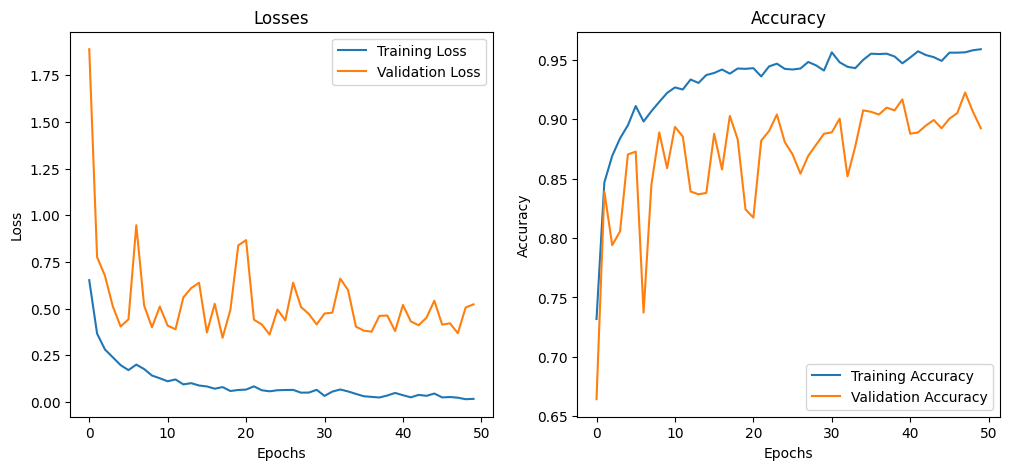

In [13]:
# グラフを保存するディレクトリを作成
output_dir = '../results'
os.makedirs(output_dir, exist_ok=True)

# タイムスタンプを生成
timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')


# LossとAccuracyのデータをCSVファイルに保存
csv_filename = os.path.join(output_dir, f'ResNet34_{timestamp}.csv')
with open(csv_filename, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Epoch', 'Training Loss', 'Validation Loss', 'Training Accuracy', 'Validation Accuracy'])
    
    for epoch in range(len(train_losses)):
        writer.writerow([epoch+1, train_losses[epoch], val_losses[epoch], train_accuracies[epoch], val_accuracies[epoch]])


# Lossのグラフを保存
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title(f'Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracyのグラフを保存
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title(f'Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# 画像を保存
plt.savefig(os.path.join(output_dir, f'ResNet34_{timestamp}.png'))

# 画像を表示
plt.show()
